Initialized
Average loss at step  0 :  262.90234375
  Nearest to ): //1.gravatar.com/avatar/59e58d0dbf76ab66dbe966460053b076, chains, kerestes, ng-partner, sharpe,
  Nearest to up: longest, president's, carolyn, report_, pumps,
  Nearest to a: brunswick, pairing, 23-year, aftermath, steubenville,
  Nearest to out: jockey/trainer, lungs, brakes, race, chores,
  Nearest to with: modify, downgrade, wilbon, shonda, bing,
  Nearest to 's: melnick, saxophonist, chemicals, ruff, stranded,
  Nearest to after: kroll, walton, determined, screeching, lg=all,
  Nearest to from: superhero, //www.chicagonow.com/mom-think-poignant/category/life-in-the-south, rogers, truthfully, newfoundland,
Average loss at step  2000 :  151.131816242
Average loss at step  4000 :  78.9401989379
Average loss at step  6000 :  54.6404061232
Average loss at step  8000 :  40.9051350263
Average loss at step  10000 :  33.2095548489
Average loss at step  12000 :  27.3810426913
Average loss at step  14000 :  23.7464107103
Ave

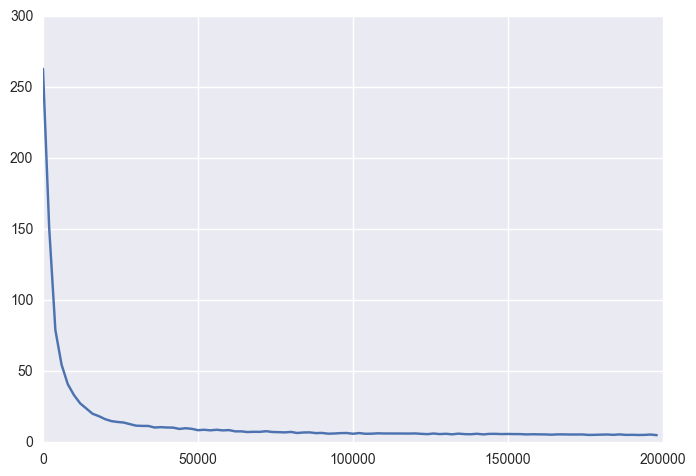

In [10]:
import random
import math

import load_data as ld
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import collections
import nltk

import pickle



LOAD_INDEXED = True

def all_words():
    global len_all_words
    len_all_words = 0
    for txt in df['bodytext']:
        tokens = nltk.tokenize.word_tokenize(txt.lower())
        for t in tokens:
            yield t
            len_all_words += 1


def pickle_indexed(data, count, dictionary, reverse_dictionary):
    with open('../data/tf_dataset.pkl', 'wb') as f:
        data_set = {'data': data,
                    'count': count,
                    'dictionary': dictionary,
                    'reverse_dictionary': reverse_dictionary}
        pickle.dump(data_set, f) #~400 MB


def unpickle_indexed():
    with open('../data/tf_dataset.pkl', 'rb') as f:
        return pickle.load(f)

if LOAD_INDEXED:
    data_set = unpickle_indexed()
    data = np.array(data_set['data'])
    count = data_set['count']
    dictionary = data_set['dictionary']
    reverse_dictionary = data_set['reverse_dictionary']
    del data_set
    vocabulary_size = len(count)
else:
    df = ld.load_data()

    # adapted from tensorflow github:
    # .../tensorflow/examples/tutorials/word2vec/word2vec_basic.py
    def build_dataset(words, vocabulary_size):
        count = [['UNK', -1]]
        count.extend(collections.Counter(words()).most_common(vocabulary_size - 1))
        global len_all_words
        dictionary = dict()
        for word, _ in count:
            dictionary[word] = len(dictionary)
        data = np.zeros(len_all_words)
        for i, word in enumerate(words()):
            if word in dictionary:
                index = dictionary[word]
            else:
                index = 0
                unk_count += 1
            data[i] = index
        count[0][1] = unk_count
        reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
        return data, count, dictionary, reverse_dictionary


    vocabulary_size = 50000
    data, count, dictionary, reverse_dictionary = build_dataset(all_words, vocabulary_size)
    pickle_indexed(data, count, dictionary, reverse_dictionary)



data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buff = collections.deque(maxlen=span)
    for _ in range(span):
        buff.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buff
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buff[skip_window]
            labels[i * num_skips + j, 0] = buff[target]
        buff.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels


# batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
# for i in range(8):
#     print(batch[i], reverse_dictionary[batch[i]],
#                 '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 8      # Random set of words to evaluate similarity on.
top_k = 5           # number of nearest neighbors
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable(
                tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
                tf.truncated_normal([vocabulary_size, embedding_size],
                                    stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    loss = tf.reduce_mean(
            tf.nn.nce_loss(weights=nce_weights,
                           biases=nce_biases,
                           labels=train_labels,
                           inputs=embed,
                           num_sampled=num_sampled,
                           num_classes=vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(
        valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.global_variables_initializer()

num_steps = 200000

losses = []
with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print("Initialized")

    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            losses.append(average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 20000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = "  Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

plt.plot(np.arange(len(losses)) * 2000.0, losses)
plt.show()